In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.insert(0,'/content/drive/My Drive/MSc_Project_Colab/BAD_PyTorch/')

**CNN**

In [4]:
!pip install torchaudio librosa boto3

     |████████████████████████████████| 1.9 MB 9.3 MB/s 
     |████████████████████████████████| 131 kB 67.1 MB/s 
     |████████████████████████████████| 831.4 MB 6.7 kB/s 
     |████████████████████████████████| 8.0 MB 56.8 MB/s 
     |████████████████████████████████| 79 kB 10.5 MB/s 
     |████████████████████████████████| 138 kB 103.2 MB/s 
     |████████████████████████████████| 127 kB 94.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu111 requires torch==1.9.0, but you have torch 1.9.1 which is incompatible

In [5]:
from torch import nn
from torchsummary import summary


class CNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding='valid'
            ),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding='valid'
            ),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding='valid'
            ),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding='valid'
            ),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0)
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.linearA = nn.Linear(448, 256)
        self.batchnormA = nn.BatchNorm1d(256)
        self.leakyrelu = nn.LeakyReLU(0.001)
        self.linearB = nn.Linear(256, 32)
        self.batchnormB = nn.BatchNorm1d(32)

        self.linear = nn.Linear(32, 1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linearA(x)
        x = self.batchnormA(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.linearB(x)
        x = self.batchnormB(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        logits = self.linear(x)

        # predictions = self.sigmoid(logits)
        return logits


if __name__ == "__main__":
    cnn = CNNNetwork()
    summary(cnn.cuda(), (1, 80, 698))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 78, 696]             160
       BatchNorm2d-2          [-1, 16, 78, 696]              32
         LeakyReLU-3          [-1, 16, 78, 696]               0
         MaxPool2d-4          [-1, 16, 26, 232]               0
            Conv2d-5          [-1, 16, 24, 230]           2,320
       BatchNorm2d-6          [-1, 16, 24, 230]              32
         LeakyReLU-7          [-1, 16, 24, 230]               0
         MaxPool2d-8            [-1, 16, 8, 76]               0
            Conv2d-9            [-1, 16, 6, 74]           2,320
      BatchNorm2d-10            [-1, 16, 6, 74]              32
        LeakyReLU-11            [-1, 16, 6, 74]               0
        MaxPool2d-12            [-1, 16, 6, 24]               0
           Conv2d-13            [-1, 16, 4, 22]           2,320
      BatchNorm2d-14            [-1, 16

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
#@title Prepare data and utility functions. {display-mode: "form"}
#@markdown
#@markdown You do not need to look into this cell.
#@markdown Just execute once and you are good to go.
#@markdown
#@markdown In this tutorial, we will use a speech data from [VOiCES dataset](https://iqtlabs.github.io/voices/), which is licensed under Creative Commos BY 4.0.

#-------------------------------------------------------------------------------
# Preparation of data and helper functions.
#-------------------------------------------------------------------------------
import io
import os
import math
import tarfile
import multiprocessing

import scipy
import librosa
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import requests
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import Audio, display

[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
  matplotlib.rcParams['figure.figsize'] = [width * 2.5, height]

_SAMPLE_DIR = "_sample_data"
SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(_SAMPLE_DIR, "steam.wav")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"
SAMPLE_RIR_PATH = os.path.join(_SAMPLE_DIR, "rir.wav")

SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
SAMPLE_NOISE_PATH = os.path.join(_SAMPLE_DIR, "bg.wav")

SAMPLE_MP3_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3"
SAMPLE_MP3_PATH = os.path.join(_SAMPLE_DIR, "steam.mp3")

SAMPLE_GSM_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.gsm"
SAMPLE_GSM_PATH = os.path.join(_SAMPLE_DIR, "steam.gsm")

SAMPLE_TAR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit.tar.gz"
SAMPLE_TAR_PATH = os.path.join(_SAMPLE_DIR, "sample.tar.gz")
SAMPLE_TAR_ITEM = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

S3_BUCKET = "pytorch-tutorial-assets"
S3_KEY = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

YESNO_DATASET_PATH = os.path.join(_SAMPLE_DIR, "yes_no")
os.makedirs(YESNO_DATASET_PATH, exist_ok=True)
os.makedirs(_SAMPLE_DIR, exist_ok=True)

def _fetch_data():
  uri = [
    (SAMPLE_WAV_URL, SAMPLE_WAV_PATH),
    (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
    (SAMPLE_RIR_URL, SAMPLE_RIR_PATH),
    (SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH),
    (SAMPLE_MP3_URL, SAMPLE_MP3_PATH),
    (SAMPLE_GSM_URL, SAMPLE_GSM_PATH),
    (SAMPLE_TAR_URL, SAMPLE_TAR_PATH),
  ]
  for url, path in uri:
    with open(path, 'wb') as file_:
      file_.write(requests.get(url).content)

_fetch_data()

def _download_yesno():
  if os.path.exists(os.path.join(YESNO_DATASET_PATH, "waves_yesno.tar.gz")):
    return
  torchaudio.datasets.YESNO(root=YESNO_DATASET_PATH, download=True)

YESNO_DOWNLOAD_PROCESS = multiprocessing.Process(target=_download_yesno)
YESNO_DOWNLOAD_PROCESS.start()

def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

def get_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_PATH, resample=resample)

def get_rir_sample(*, resample=None, processed=False):
  rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
  if not processed:
    return rir_raw, sample_rate
  rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  rir = rir / torch.norm(rir, p=2)
  rir = torch.flip(rir, [1])
  return rir, sample_rate

def get_noise_sample(*, resample=None):
  return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def inspect_file(path):
  print("-" * 10)
  print("Source:", path)
  print("-" * 10)
  print(f" - File size: {os.path.getsize(path)} bytes")
  print(f" - {torchaudio.info(path)}")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)

def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  waveform, _ = get_speech_sample()
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)

def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Kaldi Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
  axis.set_ylim((-1.3, 1.3))

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, nfcc.shape[1])
  ln2 = axis2.plot(
      time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

  lns = ln1 + ln2
  labels = [l.get_label() for l in lns]
  axis.legend(lns, labels, loc=0)
  plt.show(block=False)

DEFAULT_OFFSET = 201
SWEEP_MAX_SAMPLE_RATE = 48000
DEFAULT_LOWPASS_FILTER_WIDTH = 6
DEFAULT_ROLLOFF = 0.99
DEFAULT_RESAMPLING_METHOD = 'sinc_interpolation'

def _get_log_freq(sample_rate, max_sweep_rate, offset):
  """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

  offset is used to avoid negative infinity `log(offset + x)`.

  """
  half = sample_rate // 2
  start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
  return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset

def _get_inverse_log_freq(freq, sample_rate, offset):
  """Find the time where the given frequency is given by _get_log_freq"""
  half = sample_rate // 2
  return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

def _get_freq_ticks(sample_rate, offset, f_max):
  # Given the original sample rate used for generating the sweep,
  # find the x-axis value where the log-scale major frequency values fall in
  time, freq = [], []
  for exp in range(2, 5):
    for v in range(1, 10):
      f = v * 10 ** exp
      if f < sample_rate // 2:
        t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
        time.append(t)
        freq.append(f)
  t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
  time.append(t_max)
  freq.append(f_max)
  return time, freq

def plot_sweep(waveform, sample_rate, title, max_sweep_rate=SWEEP_MAX_SAMPLE_RATE, offset=DEFAULT_OFFSET):
  x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
  y_ticks = [1000, 5000, 10000, 20000, sample_rate//2]

  time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
  freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
  freq_y = [f for f in freq if f >= 1000 and f in y_ticks and f <= sample_rate // 2]

  figure, axis = plt.subplots(1, 1)
  axis.specgram(waveform[0].numpy(), Fs=sample_rate)
  plt.xticks(time, freq_x)
  plt.yticks(freq_y, freq_y)
  axis.set_xlabel('Original Signal Frequency (Hz, log scale)')
  axis.set_ylabel('Waveform Frequency (Hz)')
  axis.xaxis.grid(True, alpha=0.67)
  axis.yaxis.grid(True, alpha=0.67)
  figure.suptitle(f'{title} (sample rate: {sample_rate} Hz)')
  plt.show(block=True)

def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal

def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=DEFAULT_LOWPASS_FILTER_WIDTH,
    rolloff=DEFAULT_ROLLOFF,
    resampling_method=DEFAULT_RESAMPLING_METHOD,
    beta=None,
    librosa_type=None,
    iters=5
):
  if method == "functional":
    begin = time.time()
    for _ in range(iters):
      F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                 rolloff=rolloff, resampling_method=resampling_method)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "transforms":
    resampler = T.Resample(sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                           rolloff=rolloff, resampling_method=resampling_method, dtype=waveform.dtype)
    begin = time.time()
    for _ in range(iters):
      resampler(waveform)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "librosa":
    waveform_np = waveform.squeeze().numpy()
    begin = time.time()
    for _ in range(iters):
      librosa.resample(waveform_np, sample_rate, resample_rate, res_type=librosa_type)
    elapsed = time.time() - begin
    return elapsed / iters

Process Process-1:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-6-02a9d5fabd2c>", line 82, in _download_yesno
    torchaudio.datasets.YESNO(root=YESNO_DATASET_PATH, download=True)
NameError: name 'torchaudio' is not defined


In [7]:
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import os
import torch

import matplotlib
import matplotlib.pyplot as plt

import math
from random import randint
from random import uniform
from random import random

class DCASE_Dataset(Dataset):

  def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device,
                 resample_device, 
                 sig_seed, 
                 noise_bool: bool = False,
                 combi_audio_bool: bool = False,
                 pitch_bool: bool = False,
                 speed_bool: bool = False,
                 cyc_bool: bool = False):
    self.annotations = pd.read_csv(annotations_file)
    self.audio_dir = audio_dir
    self.device = device
    self.transformation = transformation.to(self.device)
    self.target_sample_rate = target_sample_rate
    self.num_samples = num_samples
    self.pitch_bool = pitch_bool
    self.noise_bool = noise_bool
    self.combi_audio_bool = combi_audio_bool
    self.speed_bool = speed_bool
    self.cyc_bool = cyc_bool
    self.resample_device = resample_device
    self.sig_seed = sig_seed
    self.randint = randint
    self.uniform = uniform
    self.random = random
    self.size = len(self.annotations) - 1
    # self.lpf_cutoff = 1000

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    audio_sample_path = self._get_audio_sample_path(index)
    label = self._get_audio_sample_label(index)
    # signal, sr = torchaudio.load(audio_sample_path, normalize=True) 

    if self.pitch_bool is True:
      pitch_val = str(randint(-200, 200))
      # print(pitch_val)
      effects = [
              ['gain', '-n'],
              ['pitch', pitch_val]  
      ]
    else:
      effects = [
        ['gain', '-n']
      ] 

    signal, sr = torchaudio.sox_effects.apply_effects_file(audio_sample_path, effects, channels_first=True)       
    if (sr % 2) != 0:
      sr = sr + 1
    # print(sr)
    signal = signal.to(self.device)    
    signal = self._resample_if_necessary(signal, sr)
    signal = self._mix_down_if_necessary(signal)
    signal = self._cut_if_necessary(signal)
    signal = self._right_pad_if_necessary(signal)
    signal = self._add_background_noise(signal)
    signal = self._combine_audio(signal, label)
    signal = self._cyclic_shift(signal)
    # signal = torchaudio.functional.highpass_biquad(signal, sr, cutoff_freq=self.lpf_cutoff)

    # plot_waveform(signal.cpu(), self.target_sample_rate, title="Processed Audio")
    # plot_specgram(signal.cpu(), self.target_sample_rate, title="Processed Audio")
    # play_audio(signal.cpu(), self.target_sample_rate)

    signal = self.transformation(signal) 
    return signal, label

  def _cut_if_necessary(self, signal):
      if signal.shape[1] > self.num_samples:
          signal = signal[:, :self.num_samples]
      return signal

  def _right_pad_if_necessary(self, signal):
      length_signal = signal.shape[1]
      if length_signal < self.num_samples:
          num_missing_samples = self.num_samples - length_signal
          last_dim_padding = (0, num_missing_samples)
          signal = torch.nn.functional.pad(signal, last_dim_padding)
      return signal

  def _resample_if_necessary(self, signal, sr):
    if self.speed_bool is True:
        if self.resample_device is 'cuda':
          speed_float = uniform(0.8, 1.2)
          speed = int(self.target_sample_rate * speed_float)
          if (speed % 2) != 0:
            speed = speed + 1
          # print(speed)
          resampler = torchaudio.transforms.Resample(sr, speed).cuda()
          signal = resampler(signal)
        else:
          speed_float = uniform(0.8, 1.2)
          speed = int(self.target_sample_rate * speed_float)
          if (speed % 2) != 0:
            speed = speed + 1
          resampler = torchaudio.transforms.Resample(sr, speed)
          signal = resampler(signal)
        return signal
    elif sr != self.target_sample_rate:
        if self.resample_device is 'cuda':
          resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).cuda()
          signal = resampler(signal)
        else:
          resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
          signal = resampler(signal)
    return signal

  def _mix_down_if_necessary(self, signal):
    if signal.shape[0] > 1: 
        signal = torch.mean(signal, dim=0, keepdim=True)
    return signal

  def _add_background_noise(self, signal):
    if self.noise_bool is False:
        return signal
    bird = signal
    # test code
    # effects_n = [
    #           #  ['gain', '-n']
    #            ]

    noise, sr = torchaudio.load('/content/drive/My Drive/MSc_Project_Colab/pink_noise.aiff', normalize=True)

    # test code
    # noise, sr = torchaudio.sox_effects.apply_effects_file('/content/drive/My Drive/MSc_Project_Colab/pink_noise.aiff', effects_n, channels_first=True)
    # noise = torchaudio.functional.highpass_biquad(noise, sr, cutoff_freq=self.lpf_cutoff)

    noise = noise.to(self.device)
    noise = self._resample_if_necessary(noise, sr)
    noise = self._mix_down_if_necessary(noise)
    noise = self._cut_if_necessary(noise)
    noise = self._right_pad_if_necessary(noise)

    # plot_waveform(noise.cpu(), self.target_sample_rate, title="Background noise")
    # plot_specgram(noise.cpu(), self.target_sample_rate, title="Background noise")
    # play_audio(noise.cpu(), self.target_sample_rate)

    bird_power = bird.norm(p=2)
    noise_power = noise.norm(p=2)

    snr_db = randint(3,10)
    snr = math.exp(snr_db / 10)
    scale = snr * noise_power / bird_power
    noisy_bird = (scale * bird + noise) / 2

    # plot_waveform(noisy_bird.cpu(), self.target_sample_rate, title=f"SNR: {snr_db} [dB]")
    # plot_specgram(noisy_bird.cpu(), self.target_sample_rate, title=f"SNR: {snr_db} [dB]")
    # play_audio(noisy_bird.cpu(), self.target_sample_rate)

    return noisy_bird

  def _combine_audio(self, signal, label):
    if self.combi_audio_bool is False:
        return signal

    rand_bird_index = self.randint(0,self.size)
    if label == 0 and self._get_audio_sample_label(rand_bird_index) == 1:
      print(f'main sound: {label}, background sound: {self._get_audio_sample_label(rand_bird_index)}')
      return signal

    print(f'main sound: {label}, background sound: {self._get_audio_sample_label(rand_bird_index)}')

    # effects_bg = [
    #           #  ['gain', '-n']
    #            ]

    bird_main = signal

    bird_bg = self._get_audio_sample_path(rand_bird_index)
    bg, sr = torchaudio.load(bird_bg, normalize=True)
    # bg, sr = torchaudio.sox_effects.apply_effects_file(bird_bg, effects_bg, channels_first=True)
    # bg = torchaudio.functional.highpass_biquad(bg, sr, cutoff_freq=self.lpf_cutoff)

    bg = bg.to(self.device)
    bg = self._resample_if_necessary(bg, sr)
    bg = self._mix_down_if_necessary(bg)
    bg = self._cut_if_necessary(bg)
    bg = self._right_pad_if_necessary(bg)

    # plot_waveform(bg.cpu(), self.target_sample_rate, title="Added audio")
    # plot_specgram(bg.cpu(), self.target_sample_rate, title="Added audio")
    # play_audio(bg.cpu(), self.target_sample_rate)

    bird_main_power = bird_main.norm(p=2)
    bg_power = bg.norm(p=2)

    
    snr_db = randint(3,10)
    snr = math.exp(snr_db / 10)
    scale = snr * bg_power / bird_main_power
    combined_sig = (scale * bird_main + bg) / 2

    # plot_waveform(combined_sig.cpu(), self.target_sample_rate, title=f"SNR: {snr_db} [dB]")
    # plot_specgram(combined_sig.cpu(), self.target_sample_rate, title=f"SNR: {snr_db} [dB]")
    # play_audio(combined_sig.cpu(), self.target_sample_rate)

    return combined_sig

  def _cyclic_shift(self, signal):
    if self.cyc_bool is False:
      return signal
    
    shift = random()
    shift = int(self.num_samples * shift)
    signal = torch.roll(signal, shift, dims=1)
    return signal

  def _get_audio_sample_path(self, index):
    fold = f"{self.annotations.iloc[index, 1]}"
    path = os.path.join(self.audio_dir, fold, f"{self.annotations.iloc[index, 0]}.wav")
    print(path)
    return path

  def _get_audio_sample_label(self, index):
    return self.annotations.iloc[index, 2]




  

  




Train the model

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/DCASE_Datasets/audio/warblrb10k/081b6d8e-6a0f-4539-a944.wav
/content/drive/My Drive/DCASE_Datasets/audio/ff1010bird/161933.wav
/content/drive/My Drive/DCASE_Datasets/audio/ff1010bird/69422.wav
/content/drive/My Drive/DCASE_Datasets/audio/warblrb10k/4f6a552f-351d-456c-b990.wav
/content/drive/My Drive/DCASE_Datasets/audio/warblrb10k/c50e3485-5b59-405b-9334.wav
/content/drive/My Drive/DCASE_Datasets/audio/warblrb10k/dc62e990-f6b4-415e-91ab.wav
/content/drive/My Drive/DCASE_Datasets/audio/ff1010bird/101412.wav
/content/drive/My Drive/DCASE_Datasets/audio/warblrb10k/81142eb5-756c-4fd4-b6fc.wav
/content/drive/My Drive/DCASE_Datasets/audio/ff1010bird/185131.wav
/content/drive/My Drive/DCASE_Datasets/audio/warblrb10k/af65f020-f2fe-4fcd-a402.wav
/content/drive/My Drive/DCASE_Datasets/audio/ff1010bird/112589.wav
/content/drive/My Drive/DCASE_Datasets/audio/warblrb10k/e8645a63-e05d-4ab3-b8a8.wav
/content/drive/My Drive/DCA

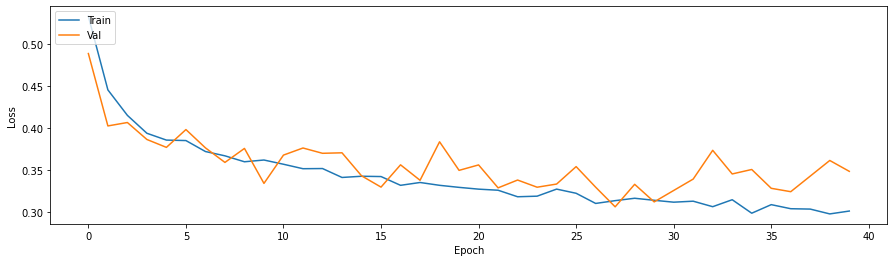

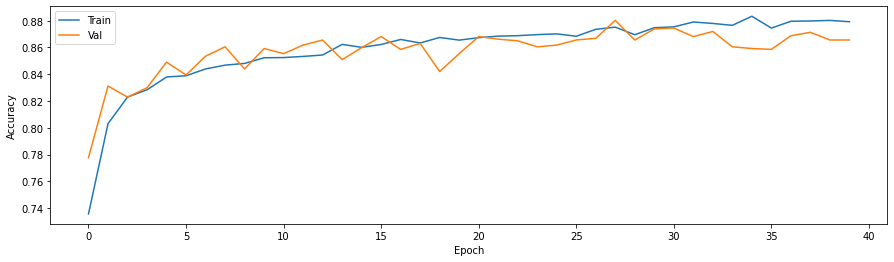

In [12]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchaudio
from random import seed
from random import random
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

# from dcasedataset_sig import DCASE_Dataset

ANNOTATIONS_FILE_TRAIN = '/content/drive/My Drive/DCASE_Datasets/labels/train_val_csv/ff_warblr_train.csv'
ANNOTATIONS_FILE_VAL = '/content/drive/My Drive/DCASE_Datasets/labels/train_val_csv/ff_warblr_val.csv'
AUDIO_DIR = '/content/drive/My Drive/DCASE_Datasets/audio/'
SAMPLE_RATE = 22050
DURATION = 10
NUM_SAMPLES = 22050 * DURATION
RESAMPLE_DEVICE = 'cuda'
SIG_SEED = seed(667)

BATCH_SIZE = 16
EPOCHS = 40
LEARNING_RATE = 0.001

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

def create_data_loader(train_data, val_data, batch_size):
    g = torch.Generator()
    g.manual_seed(0)

    train_dataloader = DataLoader(train_data, 
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=0,
                                  worker_init_fn=seed_worker,
                                  generator=g)
    val_dataloader = DataLoader(val_data, 
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0,
                                worker_init_fn=seed_worker,
                                generator=g)
    return train_dataloader, val_dataloader


def train_single_epoch(model, data_loader, loss_fn, optimiser, device, sigmoid):
    size = len(data_loader.dataset)
    stages_per_epoch = len(data_loader)
    average_loss, correct = 0, 0
    print("Dataset size: {}".format(size))
    print("Stages per epoch {}".format(stages_per_epoch))
    
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)

        for index, signal in enumerate(input):
          # seed(0) SHOULD I REMOVE THIS?
          # value = random()

          # if value > 0:
          signal = t1masking(signal)
          signal = t2masking(signal)
          signal = fmasking(signal)
          input[index] = signal


        # def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
        #   fig, axs = plt.subplots(1, 1)
        #   axs.set_title(title or 'Spectrogram')
        #   axs.set_ylabel(ylabel)
        #   axs.set_xlabel('frame')
        #   spec = spec.cpu()
        #   spec = spec[0,:,:]
        #   im = axs.imshow(spec, origin='lower', aspect=aspect)
        #   if xmax:
        #     axs.set_xlim((0, xmax))
        #   fig.colorbar(im, ax=axs)
        #   plt.show(block=False)

        # for signal_mod in input:
        #   plot_spectrogram(signal_mod)

        # calculate train loss
        prediction = model(input)
        target = target.unsqueeze_(1)
        target = target.type(torch.cuda.FloatTensor)
        loss = loss_fn(prediction, target)
        print(f"Training loss: {loss.item()}")
        average_loss += loss.item()

        # calculate train accuracy
        pred = sigmoid(prediction)
        for i, p in enumerate(pred):
          if p > 0.5:
            p = 1
          else:
            p = 0
          if p == target[i]:
            correct += 1

        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f"Average training loss: {average_loss / stages_per_epoch}")

    # train data for loss graph
    train_loss_y.append(average_loss / stages_per_epoch)
    array_len = len(train_x)
    train_x.append(array_len)

    # train data for accuracy graph
    train_acc_y.append(correct / size)


def val_single_epoch(model, data_loader, loss_fn, device, sigmoid):
    size = len(data_loader.dataset)
    stages_per_epoch = len(data_loader)
    print(size)
    print(stages_per_epoch)
    test_loss, correct = 0, 0

    with torch.no_grad():
      for input, target in data_loader:
        # calculate validation loss
        input, target = input.to(device), target.to(device)
        prediction = model(input)
        target = target.unsqueeze_(1)
        target = target.type(torch.cuda.FloatTensor)
        loss = loss_fn(prediction, target)
        test_loss += loss.item()
        print(f"Validation loss: {loss.item()}")

        # calculate val accuracy
        pred = sigmoid(prediction)
        for i, p in enumerate(pred):
          if p > 0.5:
            p = 1
          else:
            p = 0
          if p == target[i]:
            correct += 1

    print(f"Average validation loss: {test_loss / stages_per_epoch}")

    # val data for loss graph
    val_loss_y.append(test_loss / stages_per_epoch)
    array_len = len(val_x)
    val_x.append(array_len)

    # val data for accuracy graph
    val_acc_y.append(correct / size)

def training_and_validation(model, train_loader, val_loader, loss_fn, optimiser, device, epochs, sigmoid):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_single_epoch(model, train_loader, loss_fn, optimiser, device, sigmoid)
        val_single_epoch(model, val_loader, loss_fn, device, sigmoid)
        print("---------------------------")
    print("Finished training")


if __name__ == "__main__":

    # print(randint(0, 100))

    # containers for metrics
    train_loss_y = []
    train_x = []
    val_loss_y = []
    val_x = []
    train_acc_y = []
    val_acc_y = []

    # sigmoid to calculate accuracy
    sigmoid = nn.Sigmoid()

    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using {device}")

    # instantiate dataset object and create data loader
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=316,
        n_mels=80,
        power=0.33,
        normalized=True
    )

    t1masking = torchaudio.transforms.TimeMasking(time_mask_param=40)
    t2masking = torchaudio.transforms.TimeMasking(time_mask_param=40)
    fmasking = torchaudio.transforms.FrequencyMasking(freq_mask_param=10)

    train_data = DCASE_Dataset(ANNOTATIONS_FILE_TRAIN,
                            AUDIO_DIR,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            device,
                            RESAMPLE_DEVICE,
                            SIG_SEED,
                            noise_bool=False,
                            combi_audio_bool=False,
                            pitch_bool=False,
                            speed_bool=False,
                            cyc_bool=False
                            )
    
    val_data = DCASE_Dataset(ANNOTATIONS_FILE_VAL,
                            AUDIO_DIR,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            device,
                            RESAMPLE_DEVICE,
                            SIG_SEED)
    
    train_dataloader, val_dataloader = create_data_loader(train_data, val_data, BATCH_SIZE)

    cnn = CNNNetwork().to(device)
    print(cnn)

    # initialise loss funtion + optimiser
    # loss_fn = nn.BCELoss()
    loss_fn = nn.BCEWithLogitsLoss()
    optimiser = torch.optim.Adam(cnn.parameters(), 
                                 lr=LEARNING_RATE)

    # train model
    training_and_validation(cnn, train_dataloader, val_dataloader, loss_fn, optimiser, device, EPOCHS, sigmoid)

    # save model
    torch.save(cnn.state_dict(), "/content/drive/My Drive/MSc_Project_Colab/BAD_PyTorch/cnn.pth")
    print("Trained cnn saved at cnn.pth")

    # plot the loss over train and validation dataset
    plt.plot(train_x, train_loss_y)
    plt.plot(val_x, val_loss_y)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train", "Val"], loc=2)
    plt.show()

    # plot the accuracy over train and validation dataset
    plt.plot(train_x, train_acc_y)
    plt.plot(val_x, val_acc_y)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Val"], loc=2)
    plt.show()

Streaming output truncated to the last 5000 lines.

/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/20462764-d02c-4c93-abf1-b269ccbe0888.wav
/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/20462764-d02c-4c93-abf1-b269ccbe0888.wav
tensor([[0.0126]], device='cuda:0')
0
0.012633070349693298
Predicted: 'no-bird', expected: 'no-bird'

/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/20465db7-9865-47e2-a410-da8939c96868.wav
/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/20465db7-9865-47e2-a410-da8939c96868.wav
tensor([[0.0491]], device='cuda:0')
0
0.049103911966085434
Predicted: 'no-bird', expected: 'no-bird'

/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/2046a9cd-8347-48a8-a44e-9002aaaaf21b.wav
/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/2046a9cd-8347-48a8-a44e-9002aaaaf21b.wav
tensor([[0.0503]], device='cuda:0')
0
0.05033709853887558
Predicted: 'no-bird', expected: 'no-bird'

/content/drive/My D

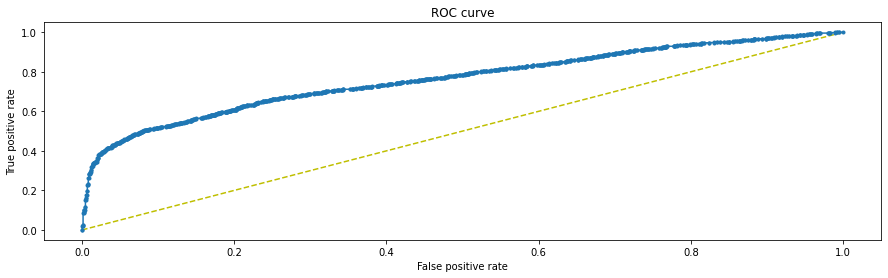

<Figure size 1080x288 with 0 Axes>

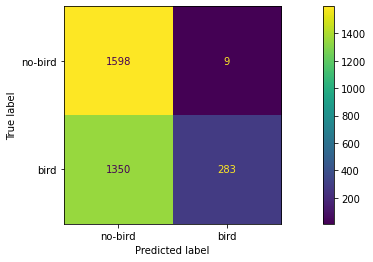

In [13]:
import torch
import torchaudio
from torch import nn

from random import seed
from random import random
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import numpy as np
import pandas as pd

# from dcasedatasetcpu import DCASE_Dataset
# from cnnbinary_uky import CNNNetwork
# from train_binary import ANNOTATIONS_FILE, AUDIO_DIR, SAMPLE_RATE, DURATION, NUM_SAMPLES

ANNOTATIONS_birdvox = '/content/drive/My Drive/DCASE_Datasets/labels/BirdVox-DCASE20k.csv'
ANNOTATIONS_warblr = '/content/drive/My Drive/DCASE_Datasets/labels/warblrb10k.csv'
ANNOTATIONS_freefield = '/content/drive/My Drive/DCASE_Datasets/labels/ff1010bird.csv'
ANNOTATIONS_mini = '/content/drive/My Drive/DCASE_Datasets/labels/mini_metadata.csv'
ANNOTATIONS_bvff_1200 = '/content/drive/My Drive/DCASE_Datasets/labels/bv_ff_1200.csv'
AUDIO_DIR = '/content/drive/My Drive/DCASE_Datasets/audio/'
SAMPLE_RATE = 22050
DURATION = 10
NUM_SAMPLES = 22050 * DURATION
RESAMPLE_DEVICE = 'cpu'
THRESHOLD = 0.5
SIG_SEED = seed(666)


class_mapping = [
    "no-bird",
    "bird"
]


def predict(model, input, target, class_mapping):
    model.eval()
    with torch.no_grad():
        predictions = model(input).cuda()
        sigmoid = nn.Sigmoid()
        predictions = sigmoid(predictions)
        print(predictions)
        pred_float = predictions[0]
        # Tensor (1, 10) -> [ [0.1, 0.01, ..., 0.6] ]
        if predictions[0] > THRESHOLD:

          # predicted_index = predictions[0].argmax(0)
          predicted_index = 1
        elif predictions[0] < THRESHOLD:
          predicted_index = 0
        print(predicted_index)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected, predicted_index, target, pred_float.item()


if __name__ == "__main__":
    # metrics
    preds = []
    targs = []
    pred_floats = []

    # load back the model
    cnn = CNNNetwork()
    state_dict = torch.load("/content/drive/My Drive/MSc_Project_Colab/BAD_PyTorch/cnn.pth", map_location=torch.device('cpu'))
    cnn.load_state_dict(state_dict)

    # load DCASE dataset
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=316,
        n_mels=80,
        power=0.33,
        normalized=True
    )

    # spectrogram augmentation
    t1masking = torchaudio.transforms.TimeMasking(time_mask_param=40)
    t2masking = torchaudio.transforms.TimeMasking(time_mask_param=40)
    fmasking = torchaudio.transforms.FrequencyMasking(freq_mask_param=10)

    dcase = DCASE_Dataset(ANNOTATIONS_birdvox,
                            AUDIO_DIR,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            "cpu",
                            RESAMPLE_DEVICE,
                            SIG_SEED)


    # get a sample from the dcase dataset for inference
    # num_files = len(dcase)
    num_files = 3240
    seed(1)
    count = 0
    index = 0
    correct = 0
    countnobird = 0
    countbird = 0
    while count < num_files:
      value = random()
      val_label = random()

      input, target = dcase[index][0], dcase[index][1]


      # if target == 1:
      #   if val_label < 0.667:
      #     index += 1
      #     continue

      # if value > 0.5:
      #   input = t1masking(input)
      #   input = t2masking(input)
      #   input = fmasking(input)
      #   input = input

      # def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
      #     fig, axs = plt.subplots(1, 1)
      #     axs.set_title(title or 'Spectrogram')
      #     axs.set_ylabel(ylabel)
      #     axs.set_xlabel('frame')
      #     spec = spec.cpu()
      #     spec = spec[0,:,:]
      #     im = axs.imshow(spec, origin='lower', aspect=aspect)
      #     if xmax:
      #       axs.set_xlim((0, xmax))
      #     fig.colorbar(im, ax=axs)
      #     plt.show(block=False)

      
      # plot_spectrogram(input)


      input.unsqueeze_(0)

      index += 1
      count += 1

      if target == 1:
        countbird += 1
      else:
        countnobird += 1

    # make an inference
      predicted, expected, pred, targ, pred_float = predict(cnn, input, target,
                                  class_mapping)
      
      print(pred_float)
      
      preds.append(pred)
      targs.append(targ)
      pred_floats.append(pred_float)

      if predicted == expected:
        correct += 1
      print(f"Predicted: '{predicted}', expected: '{expected}'")
      print()


    accuracy = correct / num_files
    print(accuracy)
    print("bird: {}".format(countbird))
    print("no-bird: {}".format(countnobird))


    # roc
    fpr, tpr, thresholds = roc_curve(targs, pred_floats)
    # print("fpr: {}, tpr: {}".format(fpr, tpr, pos_label=2))
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'y--')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show

    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
    ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
    print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

    # AUC
    auc_value = auc(fpr, tpr)
    print("Area under curve, AUC = ", auc_value)

    # confusion matrix
    cm = confusion_matrix(targs, preds)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no-bird", "bird"])
    plt.figure(2)
    disp.plot(values_format='') 

